In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
springfield_merged_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'datasets', 'springfield_nibrs_merged.csv')
springfield_merged = pd.read_csv(springfield_merged_path,index_col=0)

In [3]:
# Add a new column to the dataset to distinguish between "white & Hispanic", which we want to count as Hispanic, and "Black and Hispanic", which we want to count as Black
def combine_race_ethnicity(race, ethnicity):
    if ethnicity == 'Not Hispanic or Latino' or ethnicity == 'Unknown':
        return race
    elif race == 'Unknown' and ethnicity == 'Hispanic or Latino':
        return 'Hispanic'
    elif  race == 'White' and ethnicity == 'Hispanic or Latino':
        return 'Hispanic'
    elif race == 'Black or African American' and ethnicity == 'Hispanic or Latino':
        return race
    elif race == 'American Indian or Alaska Native' and ethnicity == 'Hispanic or Latino':
        return race
springfield_merged['Combined Race'] = springfield_merged.apply(lambda x: combine_race_ethnicity(x['Arrestee Race'],x['Arrestee Ethnicity']),axis=1)

In [4]:
# Find out the proportions of the Springfield arrests which are accounted for by each major racial group
combined_race_in_arrests = springfield_merged.groupby(by=['Combined Race'])['Arrest'].count() / len(springfield_merged)
print(combined_race_in_arrests)

Combined Race
American Indian or Alaska Native    0.000500
Asian                               0.002997
Black or African American           0.316434
Hispanic                            0.454296
Unknown                             0.007992
White                               0.217782
Name: Arrest, dtype: float64


2018 DEMOGRAPHICS FOR SPRINGFIELD FROM https://datausa.io/profile/geo/springfield-ma/#demographics (based on Census Bureau's American Community Survey)

White (non-Hispanic): 31.7%

Black or African-American (non-Hispanic and Hispanic): 20.9%

Hispanic, but not Black or African-American: 42.4%

Multiracial (non-Hispanic): 2.41%

Asian (non-Hispanic): 2.11%

Other (non-Hispanic): 0.261%

American Indian and Alaska Native (non-Hispanic): 0.176%

In [5]:
# Calculate the Relative Rate Index for each major racial group, which tells us whether each racial group is over- or under-represented in the arrest records relative to its frequency in the city's population
RRI = pd.DataFrame(index=range(6),columns=['Prevalence in Arrests','Prevalence in Population','Relative Rate Index'])
RRI.set_index(combined_race_in_arrests.index,inplace=True)
RRI['Prevalence in Arrests'] = combined_race_in_arrests
RRI.drop('Unknown',inplace=True)
RRI['Prevalence in Population'] = [0.00176, 0.0211, 0.209, 0.424, 0.317]
RRI['Relative Rate Index'] = RRI['Prevalence in Arrests'] / RRI['Prevalence in Population']

In [6]:
RRI

,Prevalence in Arrests,Prevalence in Population,Relative Rate Index
Combined Race,,,
American Indian or Alaska Native,0.000500,0.00176,0.283807
Asian,0.002997,0.02110,0.142038
Black or African American,0.316434,0.20900,1.514036
Hispanic,0.454296,0.42400,1.071452
White,0.217782,0.31700,0.687010


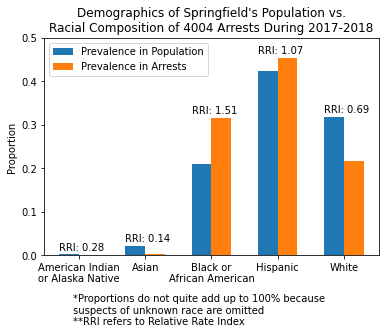

In [7]:
# Do a simple bar chart using the first two columns of the Relative Rate Index dataframe
x_locs = np.arange(5)
width = 0.3
fig, ax = plt.subplots(1)
bars1 = ax.bar(x_locs - width/2, RRI['Prevalence in Population'], width, label='Prevalence in Population')
bars2 = ax.bar(x_locs + width/2, RRI['Prevalence in Arrests'], width, label='Prevalence in Arrests')
ax.set_xticks(x_locs)
ax.set_xticklabels(['American Indian\nor Alaska Native','Asian','Black or\nAfrican American','Hispanic','White'])
ax.set_ylabel('Proportion')
ax.set_title('Demographics of Springfield\'s Population vs.\nRacial Composition of 4004 Arrests During 2017-2018')
for i in range(5):
    max_bar_height = max(bars1[i].get_height(), bars2[i].get_height())
    ax.text(x_locs[i] - width, max_bar_height + 0.01, 'RRI: ' + str(round(RRI.iloc[i]['Relative Rate Index'],2)))
ax.set_ylim(bottom=None,top=0.5)
ax.legend()
ax.text(-0.1,-0.16,'*Proportions do not quite add up to 100% because\nsuspects of unknown race are omitted\n**RRI refers to Relative Rate Index')
fig.show()